In [75]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as pl
import pymc3 as pm
import theano.tensor as tt
import matplotlib.dates as mdates
from matplotlib import rcParams
from sklearn.preprocessing import StandardScaler, scale
import pickle

In [7]:
% matplotlib inline

As a first attempt I am going to model the timeseries using a Gaussian Random Walk.
I am also going to impute the missing data by modeling it

In [3]:
years = mdates.YearLocator(day=15)
months = mdates.MonthLocator(bymonthday=15)
rcParams['xtick.major.size'] = 8
rcParams['xtick.minor.size'] = 4
rcParams['xtick.minor.visible'] = True
rcParams['xtick.labelsize'] = 16
rcParams['ytick.labelsize'] = 16
rcParams['axes.labelsize'] = 16

In [4]:
chl_file = './dataJar/seawifs_chl_monthly_15sosectors_repro2018.dat'
df = pd.read_csv(chl_file, delim_whitespace=True, parse_dates=[[0, 1 ,2]], index_col=0)

df.index.name=''
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 156 entries, 1997-09-15 to 2010-12-16
Data columns (total 15 columns):
IOSTZ      155 non-null float64
IOSAZ      155 non-null float64
IOPFZ      155 non-null float64
IOAAZ      148 non-null float64
IOSAACZ    123 non-null float64
POSTZ      155 non-null float64
POSAZ      155 non-null float64
POPFZ      124 non-null float64
POAAZ      118 non-null float64
POSAACZ    99 non-null float64
AOSTZ      153 non-null float64
AOSAZ      153 non-null float64
AOPFZ      152 non-null float64
AOAAZ      139 non-null float64
AOSAAC     126 non-null float64
dtypes: float64(15)
memory usage: 19.5 KB


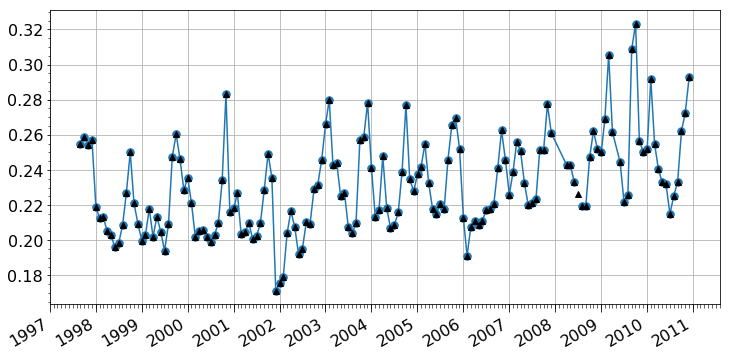

In [8]:
_, ax = pl.subplots(figsize=(12, 6))
df.IOSTZ.plot(marker='.', ax=ax, markersize=15)
df.IOSTZ.interpolate().plot(ls='', marker='^', color='k', ax=ax);
ax.xaxis_date()
ax.xaxis.set_major_locator(years)
ax.xaxis.set_minor_locator(months)
ax.grid()

In [9]:
d_iostz = df['IOSTZ'].resample('MS').mean().interpolate()
d_iostz.shape

(160,)

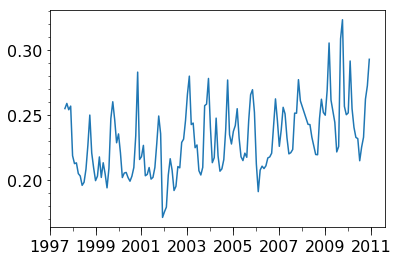

In [10]:
d_iostz.plot();

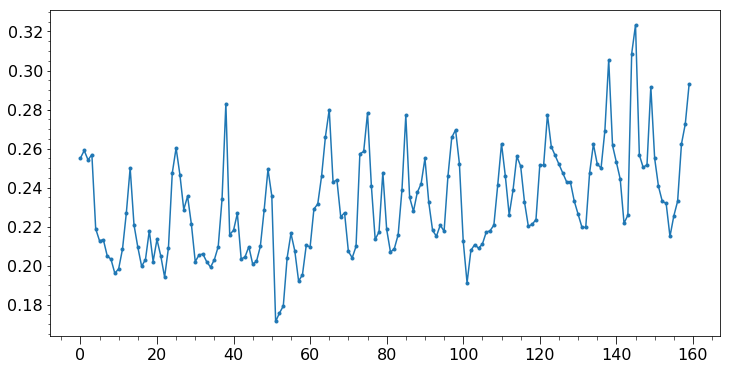

In [11]:
y = d_iostz.values
wl = 12/(2*np.pi)
x = np.arange(y.size)
f = pl.figure(figsize=(12, 6))
pl.plot(x, y, marker='.');

In [23]:
with pm.Model() as m1:
    nuMinusOne = pm.Exponential('nuMinusOne', 1/29)
    nu_ = nuMinusOne + 1
    tau = pm.Gamma('tau', 0.001, 0.001)
    beta1 = pm.Normal('beta1', 0, 10)
    beta0 = pm.Normal('beta0', 0, 10)
    trend = pm.Deterministic('trend', beta1 * 12)
    mu_ = beta0 + beta1 * x
    y_lik = pm.StudentT('y_lik', mu=mu_, lam=tau, nu=nu_, observed=y)

In [24]:
with m1:
    trace1 = pm.sample(1000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta0, beta1, tau_log__, nuMinusOne_log__]
100%|██████████| 2000/2000 [00:07<00:00, 253.26it/s]
INFO (theano.gof.compilelock): Waiting for existing lock by process '22152' (I am process '22153')
INFO (theano.gof.compilelock): To manually release the lock, delete /accounts/ekarakoy/.theano/compiledir_Linux-4.4--generic-x86_64-with-debian-stretch-sid-x86_64-3.6.5-64/lock_dir


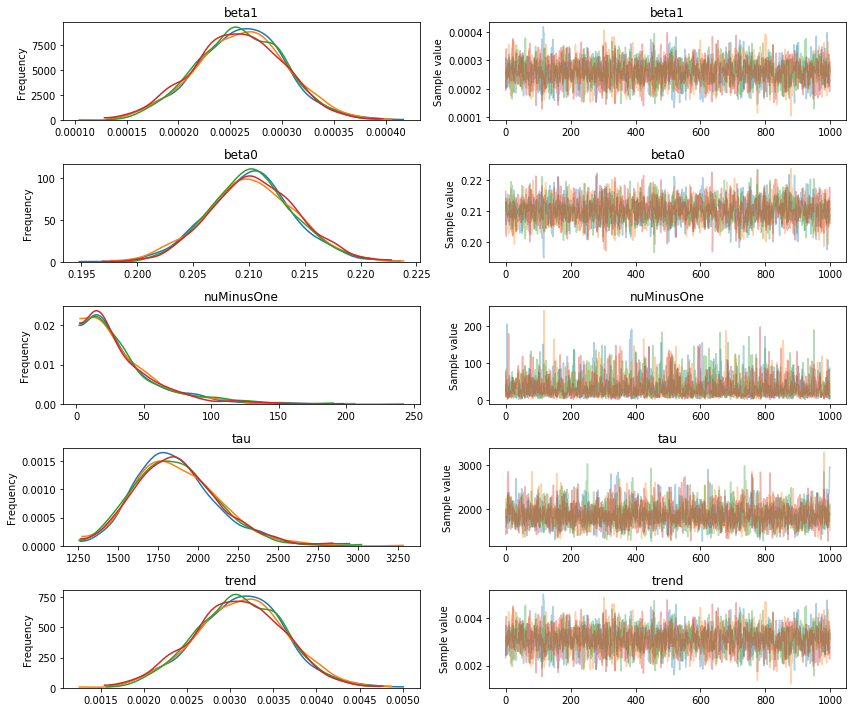

In [26]:
pm.traceplot(trace1);

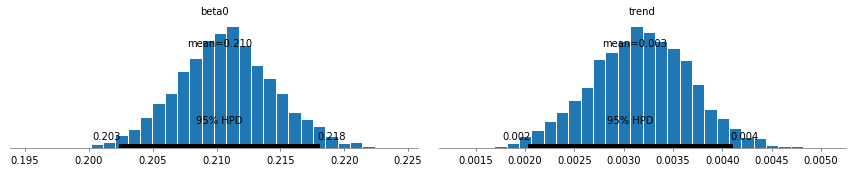

In [28]:
pm.plot_posterior(trace1, varnames=['beta0', 'trend']);

In [31]:
with pm.Model() as m1n:
    sig = pm.HalfNormal('sig', 5)
    beta1 = pm.Normal('beta1', 0, 10)
    beta0 = pm.Normal('beta0', 0, 10)
    trend = pm.Deterministic('trend', beta1 * 12)
    mu_ = beta0 + beta1 * x
    y_lik = pm.Normal('y_lik', mu=mu_, sd=sig, observed=y)

In [33]:
with m1n:
    trace_1n = pm.sample(1000, tune=1000, nuts_kwargs={'target_accept': 0.9})

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta0, beta1, sig_log__]
100%|██████████| 2000/2000 [00:03<00:00, 580.87it/s]


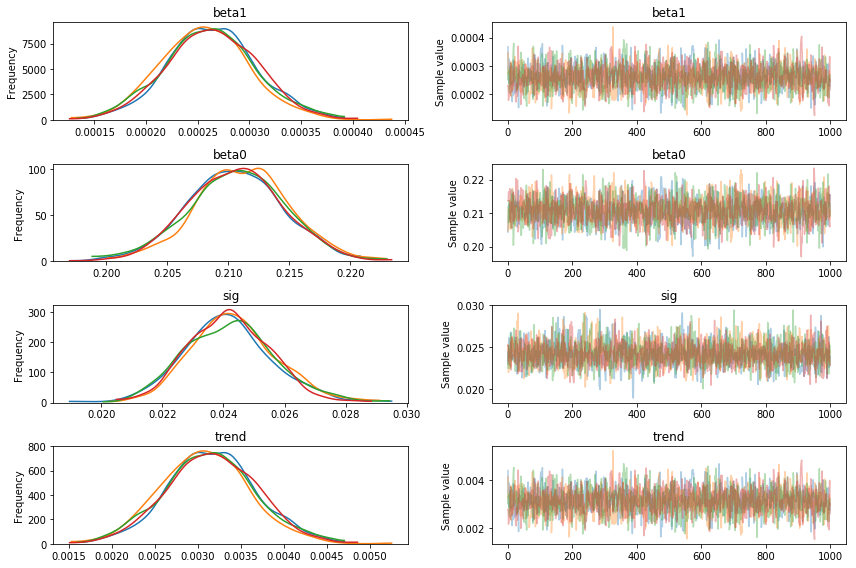

In [34]:
pm.traceplot(trace_1n);

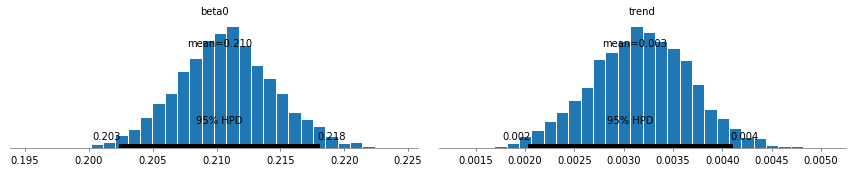

In [35]:
pm.plot_posterior(trace1, varnames=['beta0', 'trend']);

In [13]:
std_scaler = StandardScaler()

In [14]:
y_s = std_scaler.fit_transform(y.reshape(-1, 1))

In [97]:
with pm.Model() as m2_s:
    nuMinusOne = pm.Exponential('nuMinusOne', 1/29)
    nu_ = nuMinusOne + 1
    thresh = pm.Uniform('thresh', 0, 11)
    amp = pm.Uniform('amp', 0, 1)
    tau = pm.Gamma('tau', 10, 2)
    mu_ = amp * tt.cos((x - thresh)/ wl)
    y_lik = pm.StudentT('y_lik', mu=mu_, lam=tau, nu=nu_, observed=y_s)

In [98]:
with m2_s:
    trace_2_s = pm.sample(1000, tune=2000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_log__, amp_interval__, thresh_interval__, nuMinusOne_log__]
100%|██████████| 3000/3000 [00:03<00:00, 840.89it/s]


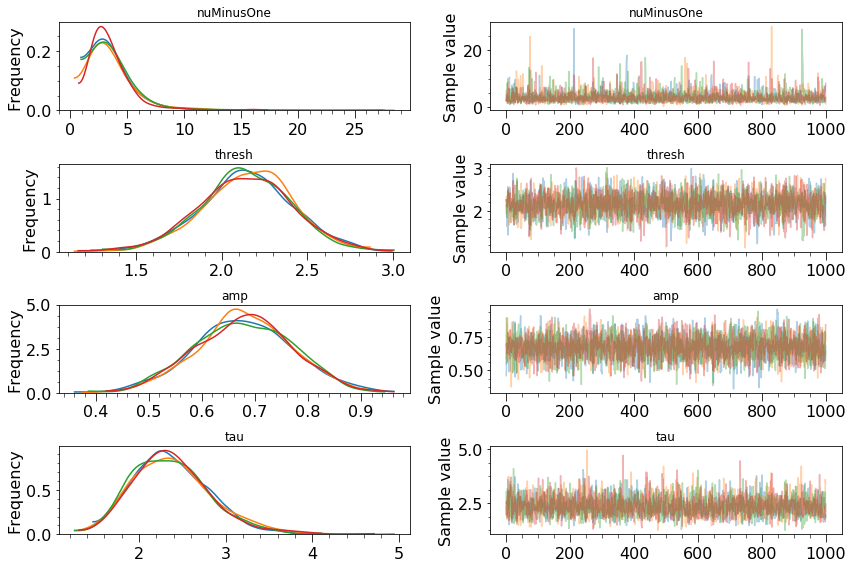

In [99]:
pm.traceplot(trace_2_s);

In [15]:
wl_lower = 11 / (2 * np.pi)
wl_upper = 13 / (2 * np.pi)

In [124]:
with pm.Model() as m2b_s:
    nuMinusOne = pm.Exponential('nuMinusOne', 1/29)
    nu_ = nuMinusOne + 1
    wl_ = pm.Uniform('wl', wl_lower, wl_upper)
    thresh = pm.Uniform('thresh', 0, 11)
    amp = pm.HalfNormal('amp', 1)
    tau = pm.Gamma('tau', 10, 2)
    mu_ = amp * tt.cos((x - thresh)/ wl_)
    y_lik = pm.StudentT('y_lik', mu=mu_, lam=tau, nu=nu_, observed=y_s)

In [125]:
with m2b_s:
    trace_2b_s = pm.sample(2000, tune=3000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_log__, amp_log__, thresh_interval__, wl_interval__, nuMinusOne_log__]
100%|██████████| 5000/5000 [00:08<00:00, 584.19it/s]


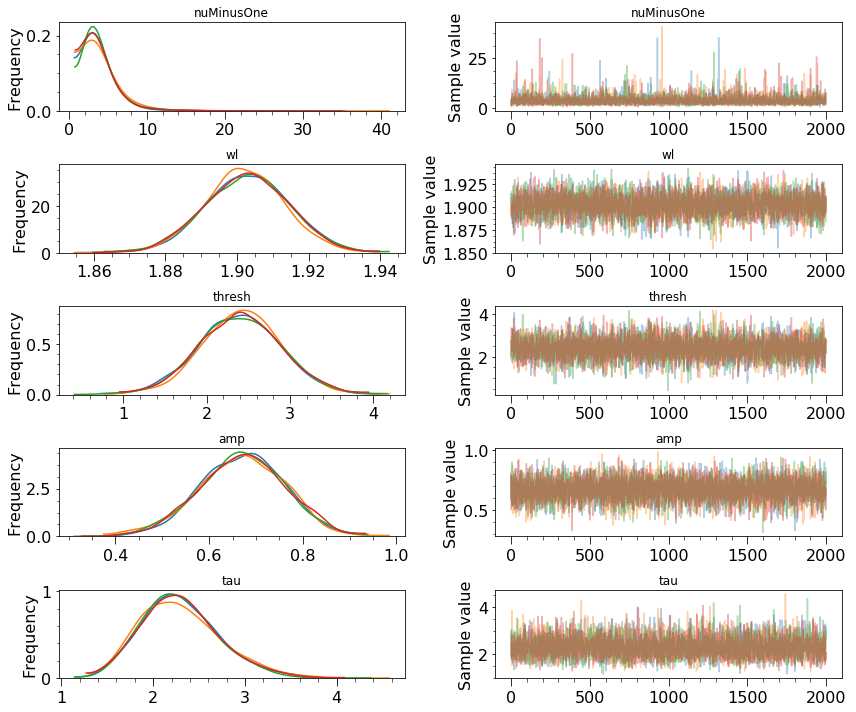

In [126]:
pm.traceplot(trace_2b_s);

In [60]:
with pm.Model() as m3:
    nuMinusOne = pm.Exponential('nuMinusOne', 1/29)
    nu_ = nuMinusOne + 1
    thresh = pm.Uniform('thresh', -6, 6)
    amp = pm.Uniform('amp', 0, 1)
    tau = pm.Gamma('tau', 10, 2)
    beta1 = pm.Normal('beta1', 0, 10)
    beta0 = pm.Normal('beta0', 0, 10)
    trend = pm.Deterministic('trend', beta1 * 12)
    mu_ = beta0 + beta1 * x + amp * tt.cos((x - thresh) / wl)
    y_lik = pm.StudentT('y_lik', mu=mu_, lam=tau, nu=nu_, observed=y)

In [61]:
with m3:
    trace_3 = pm.sample(1000, tune=2000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta0, beta1, tau_log__, amp_interval__, thresh_interval__, nuMinusOne_log__]
 42%|████▏     | 1272/3000 [00:09<00:13, 127.71it/s]/accounts/ekarakoy/anaconda3/envs/machine_learning/lib/python3.6/site-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)
100%|██████████| 3000/3000 [00:12<00:00, 233.81it/s]


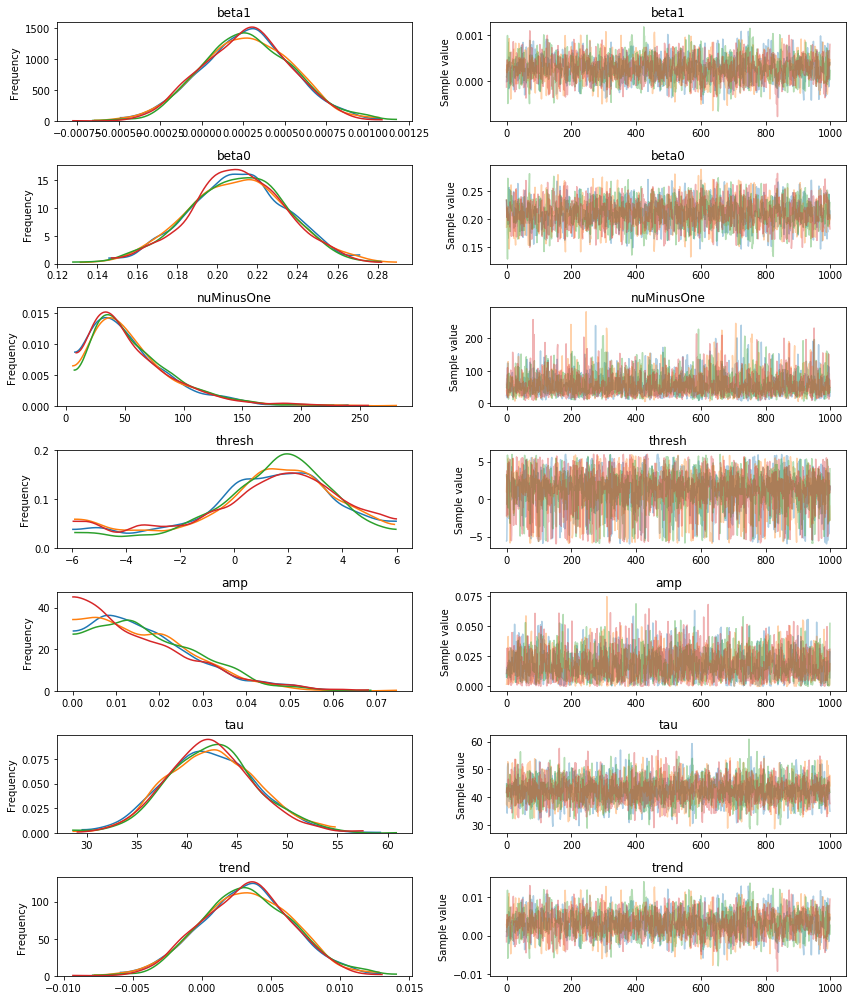

In [63]:
pm.traceplot(trace_3);

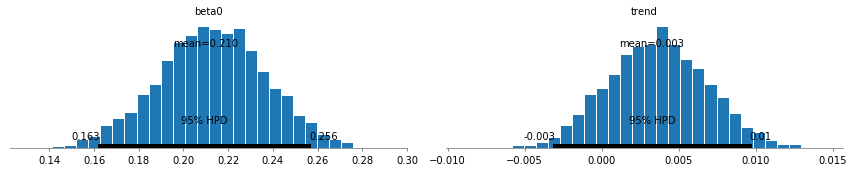

In [65]:
pm.plot_posterior(trace_3, varnames=['beta0','trend']);

In [127]:
# the model below has trouble, switching to scaled y, y_s

In [18]:
y_s = y_s.flatten()

In [21]:
with pm.Model() as m4:
    # overall estimation
    nuMinusOne = pm.Exponential('nuMinusOne', 1/29)
    nu_ = nuMinusOne + 1
    lam_ = pm.Gamma('lam', 10, 2)
    
    # seasonality estimation
    thresh = pm.Uniform('thresh', 0, 11)
    amp = pm.Uniform('amp', 0, 1)
    wl_ = pm.Uniform('wl', wl_lower, wl_upper)
    season = pm.Deterministic('season', amp * tt.cos((x - thresh)/ wl_))
    
    
    # trend estimation
    slp = pm.Normal('slope', 0, 1)
    itc = pm.Normal('intercept', 0, 1)
    trend = pm.Deterministic('trend', itc + slp * x)
    
    # residual estimation
    k_ = pm.Uniform('k', -1.1, 1.1)
    tau_ = pm.Gamma('tau', 10, 3)
    ar1 = pm.AR1('ar1', k=k_, tau_e=tau_, shape=y.size)
    #e_t = pm.Normal('e_t', 0, 1, shape=y.size)
    #mu_ = trend + season + e_t
    mu_ = pm.Deterministic('mu', trend + season + ar1)
    y_lik = pm.StudentT('y_lik', mu=mu_, lam=lam_, nu=nu_, observed=y_s)

In [22]:
with m4:
    trace_4 = pm.sample(7000, tune=10000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ar1, tau_log__, k_interval__, intercept, slope, wl_interval__, amp_interval__, thresh_interval__, lam_log__, nuMinusOne_log__]
100%|██████████| 17000/17000 [02:21<00:00, 119.99it/s]
The number of effective samples is smaller than 10% for some parameters.


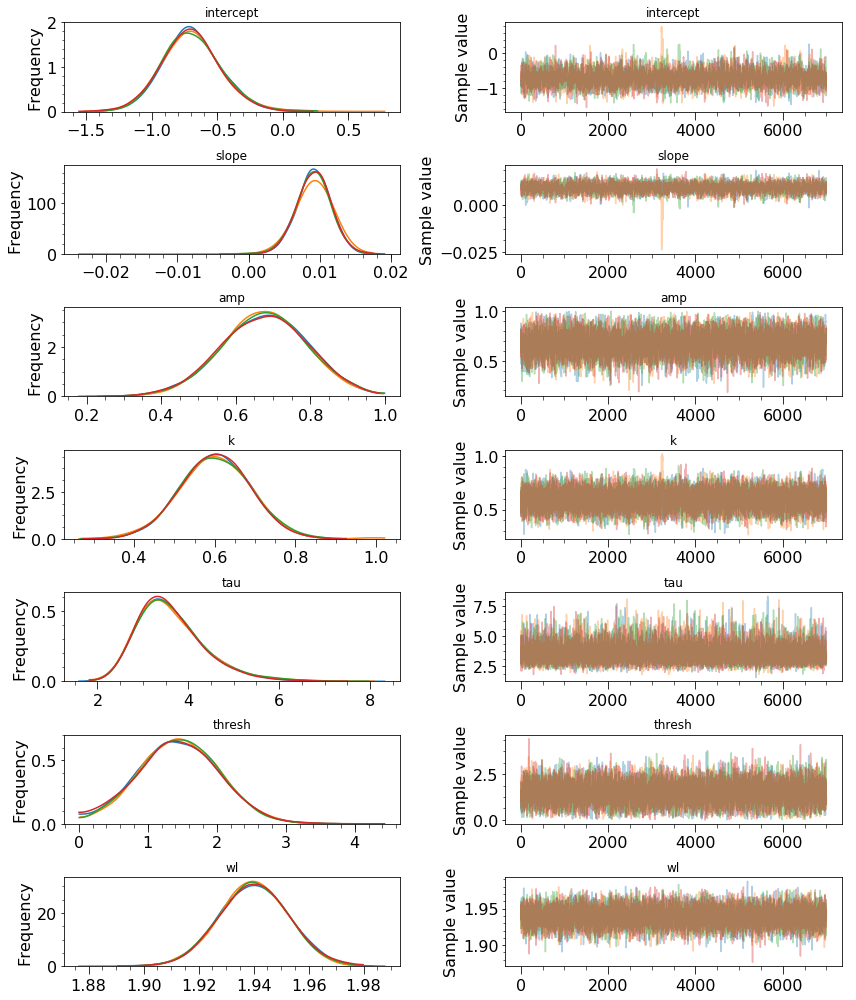

In [46]:
vars_ = ['intercept', 'slope', 'amp', 'k', 'tau', 'thresh', 'wl']
pm.traceplot(trace_4, varnames=vars_);

In [26]:
(0.01 * std_scaler.scale_)*12

array([ 0.00318242])

In [48]:
ts_mod_4 = trace_4.get_values('mu')
ts_mod_4_mu = ts_mod_4.mean(axis=0)
ts_mod_4_hpd = pm.hpd(ts_mod_4)
ts_mod_4_trend = trace_4.get_values('trend')
ts_mod_4_trend_mu = ts_mod_4_trend.mean(axis=0)
ts_mod_4_trend_hpd = pm.hpd(ts_mod_4_trend)
ts_mod_4_season = trace_4.get_values('season')
ts_mod_4_season_mu = ts_mod_4_season.mean(axis=0)
ts_mod_4_season_hpd = pm.hpd(ts_mod_4_season)
ts_mod_4_ar1 = trace_4.get_values('ar1')
ts_mod_4_ar1_mu = ts_mod_4_ar1.mean(axis=0)
ts_mod_4_ar1_hpd = pm.hpd(ts_mod_4_ar1)

In [70]:
def plot_component(axi, x, y, hpd_=None, obs=None, line_label=None, y_axis_label=None,
                  ax_title=None):
    
    if isinstance(obs, np.ndarray):
        axi.plot(x, obs, color='k', label='observations')
    axi.plot(x, y, color='darkblue', label=line_label)
    if isinstance(hpd_, np.ndarray):
        axi.fill_between(x, hpd_[:, 0], hpd_[:, 1], color='steelblue',
                         alpha=0.5, label='95% CI')
    if y_axis_label:
        axi.set_ylabel(y_axis_label)
    axi.legend()
    if ax_title:
        axi.set_title(ax_title)
    axi.grid()

In [ ]:
f, ax = pl.subplots(nrows=4, sharex=True, figsize=(12, 20))
ylbl = 'standardized chl'
plot_component(ax[0], d_iostz.index, ts_mod_4_mu, hpd_=ts_mod_4_hpd,
               obs=y_s, line_label='model_mean', y_axis_label=ylbl,
               ax_title='All Components')
plot_component(ax[1], d_iostz.index, ts_mod_4_trend_mu, hpd_=ts_mod_4_trend_hpd,
               line_label='mean', y_axis_label=ylbl, ax_title='Trend')
plot_component(ax[2], d_iostz.index, ts_mod_4_season_mu, hpd_=ts_mod_4_season_hpd,
               line_label='mean', y_axis_label=ylbl,
              ax_title='Season')
plot_component(ax[3], d_iostz.index, ts_mod_4_ar1_mu, hpd_=ts_mod_4_ar1_hpd,
              line_label='mean', y_axis_label=ylbl, ax_title='AR1')

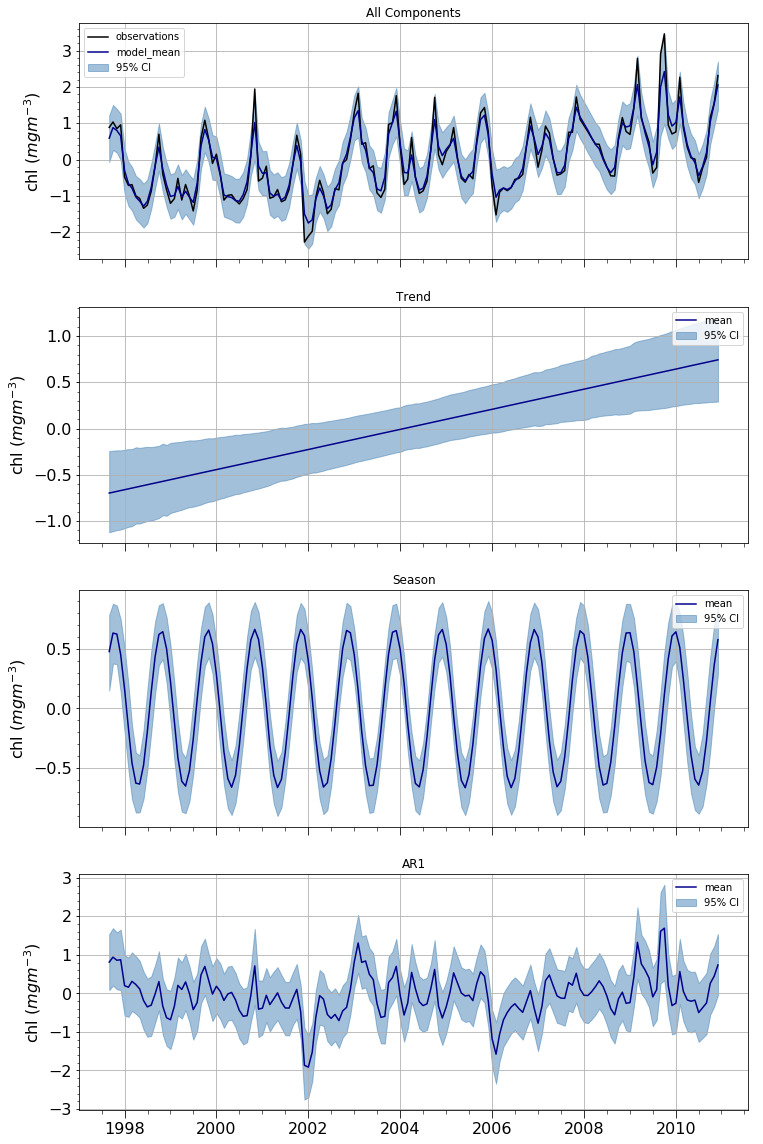

In [74]:
mod4_mu_us = std_scaler.inverse_transform(ts_mod_4_mu)
mod4_hpd_us = std_scaler.inverse_transform(ts_mod_4_hpd)
mod4_trend_hpd_us = std_scaler.inverse_transform(ts_mod_4_trend_hpd)
mod4_trend_mu_us = std_scaler.inverse_transform(ts_mod_4_trend_mu)
mod4_season_hpd_us = std_scaler.inverse_transform(ts_mod_4_season_hpd)
mod4_season_mu_us = std_scaler.inverse_transform(ts_mod_4_season_mu)
mod4_ar1_hpd_us = std_scaler.inverse_transform(ts_mod_4_ar1_hpd)
mod4_ar1_mu_us = std_scaler.inverse_transform(ts_mod_4_ar1_mu)
f, ax = pl.subplots(nrows=4, sharex=True, figsize=(12, 20))
plot_component(ax[0], d_iostz.index, mod4_mu_us, hpd_=mod4_hpd_us,
               obs=y, line_label='model_mean',
               y_axis_label='chl $(mg m^{-3})$', ax_title='All Components')
plot_component(ax[1], d_iostz.index, mod4_trend_mu_us, hpd_=mod4_trend_hpd_us,
               line_label='mean', y_axis_label='chl $(mg m^{-3})$',
              ax_title='Trend')
plot_component(ax[2], d_iostz.index, mod4_season_mu_us, hpd_=mod4_season_hpd_us,
               line_label='mean', y_axis_label='chl $(mg m^{-3})$',
              ax_title='Season')
plot_component(ax[3], d_iostz.index, mod4_ar1_mu_us, hpd_=mod4_ar1_hpd_us,
              line_label='mean', y_axis_label='chl $(mg m^{-3})$', ax_title='AR1')

In [55]:
pm.summary(trace_4, varnames=vars_)

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
beta0,-0.691205,0.228410,0.005820,-1.129365,-0.222423,1446.401421,1.002666
beta1,0.009049,0.002413,0.000057,0.004287,0.013873,1733.724778,1.000771
amp,0.669289,0.116975,0.001959,0.436429,0.897080,3197.556176,1.000207
trend_yr,0.108583,0.028959,0.000679,0.051439,0.166474,1733.724778,1.000771
k,0.599453,0.087072,0.001188,0.435560,0.777202,4750.895918,1.000345
tau,3.607400,0.742816,0.012964,2.326038,5.114566,3716.427496,1.000945
thresh,1.471342,0.585814,0.009640,0.306630,2.596705,4034.839474,1.002585
wl,1.939310,0.012531,0.000187,1.915154,1.964079,4333.912842,1.001745


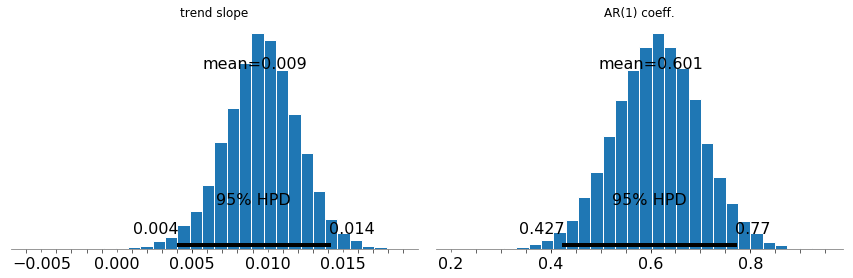

In [119]:
f, axs = pl.subplots(ncols=2, figsize=(12, 4))
pm.plot_posterior(trace_4, varnames=['slope', 'k'], ax=axs, text_size=16, );
axs[0].set_title('trend slope')
axs[1].set_title('AR(1) coeff.')
f.savefig('./figJar/model4_posterior_dists.png', dpi=300)

In [59]:
with pm.Model() as m5:
    # overall estimation
    nuMinusOne = pm.Exponential('nuMinusOne', 1/29)
    nu_ = nuMinusOne + 1
    lam_ = pm.Gamma('lam', 10, 2)
    
    # seasonality estimation
    thresh1 = pm.Normal('thresh1', 10)
    thresh2 = pm.Normal('thresh2', 10)
    amp = pm.HalfNormal('amp', 5, shape=2)
    wl_1 = pm.Uniform('wl_1', 0, 5)
    wl_2 = pm.Uniform('wl_2', 0, 5)
    season_1 = amp[0] * tt.sin((x - thresh1) / wl_1)
    season_2 = amp[1] * tt.sin((x - thresh2) / wl_2)
    season = pm.Deterministic('season', season_1 + season_2)
    
    # trend estimation
    slp = pm.Normal('slope', 0, 1)
    itc = pm.Normal('intercept', 0, 1)
    trend = pm.Deterministic('trend', itc + slp * x)
       
    # residual estimation
    k_ = pm.Uniform('k', -1.1, 1.1)
    tau_ = pm.Gamma('tau', 10, 3)
    ar1 = pm.AR1('ar1', k=k_, tau_e=tau_, shape=y.size)

    #e_t = pm.Normal('e_t', 0, 1, shape=y.size)
    #mu_ = trend + season + e_t
    mu_ = pm.Deterministic('mu_', trend + season + ar1)
    y_lik = pm.StudentT('y_lik', mu=mu_, lam=lam_, nu=nu_, observed=y_s)
    trace_5 = pm.sample(7000, tune=10000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ar1, tau_log__, k_interval__, intercept, slope, wl_2_interval__, wl_1_interval__, amp_log__, thresh2, thresh1, lam_log__, nuMinusOne_log__]
100%|██████████| 17000/17000 [06:18<00:00, 44.97it/s]
There were 7 divergences after tuning. Increase `target_accept` or reparameterize.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.


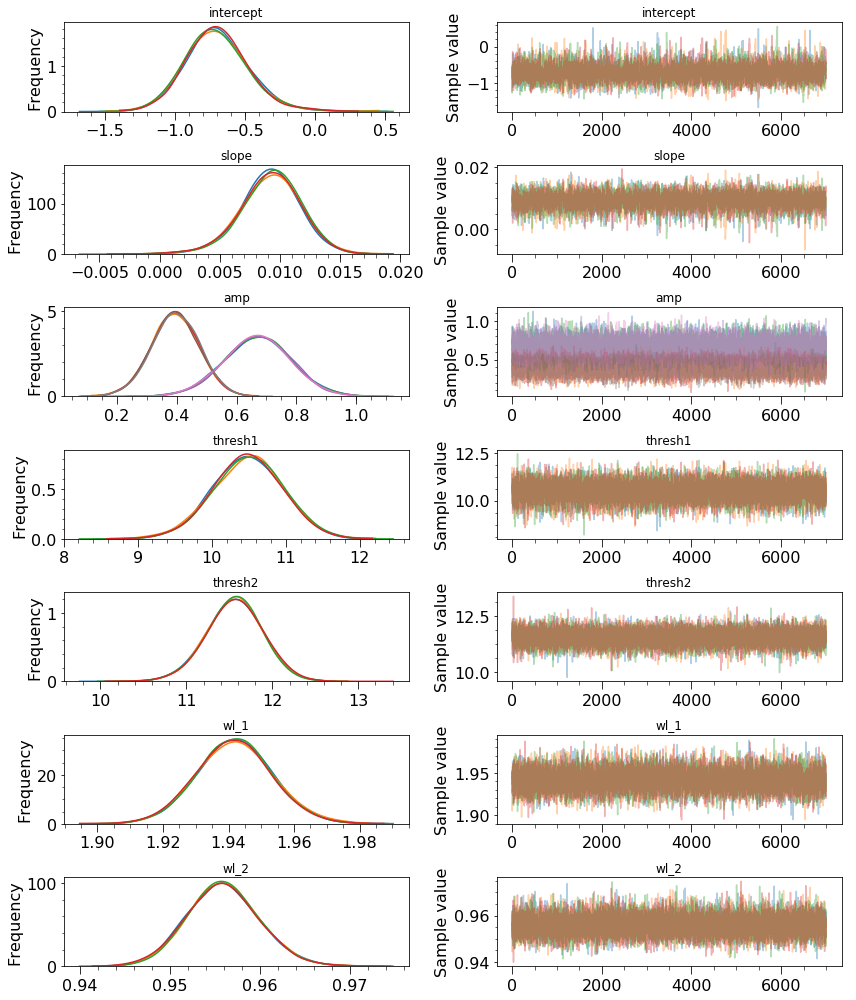

In [61]:
vars_ = ['intercept', 'slope', 'amp', 'thresh1', 'thresh2', 'wl_1', 'wl_2']
pm.traceplot(trace_5, varnames=vars_);

In [65]:
ts_mod_5 = trace_5.get_values('mu_')
ts_mod_5_mu = ts_mod_5.mean(axis=0)
ts_mod_5_hpd = pm.hpd(ts_mod_5)
ts_mod_5_trend = trace_5.get_values('trend')
ts_mod_5_trend_mu = ts_mod_5_trend.mean(axis=0)
ts_mod_5_trend_hpd = pm.hpd(ts_mod_5_trend)
ts_mod_5_season = trace_5.get_values('season')
ts_mod_5_season_mu = ts_mod_5_season.mean(axis=0)
ts_mod_5_season_hpd = pm.hpd(ts_mod_5_season)
ts_mod_5_ar1 = trace_5.get_values('ar1')
ts_mod_5_ar1_mu = ts_mod_5_ar1.mean(axis=0)
ts_mod_5_ar1_hpd = pm.hpd(ts_mod_5_ar1)

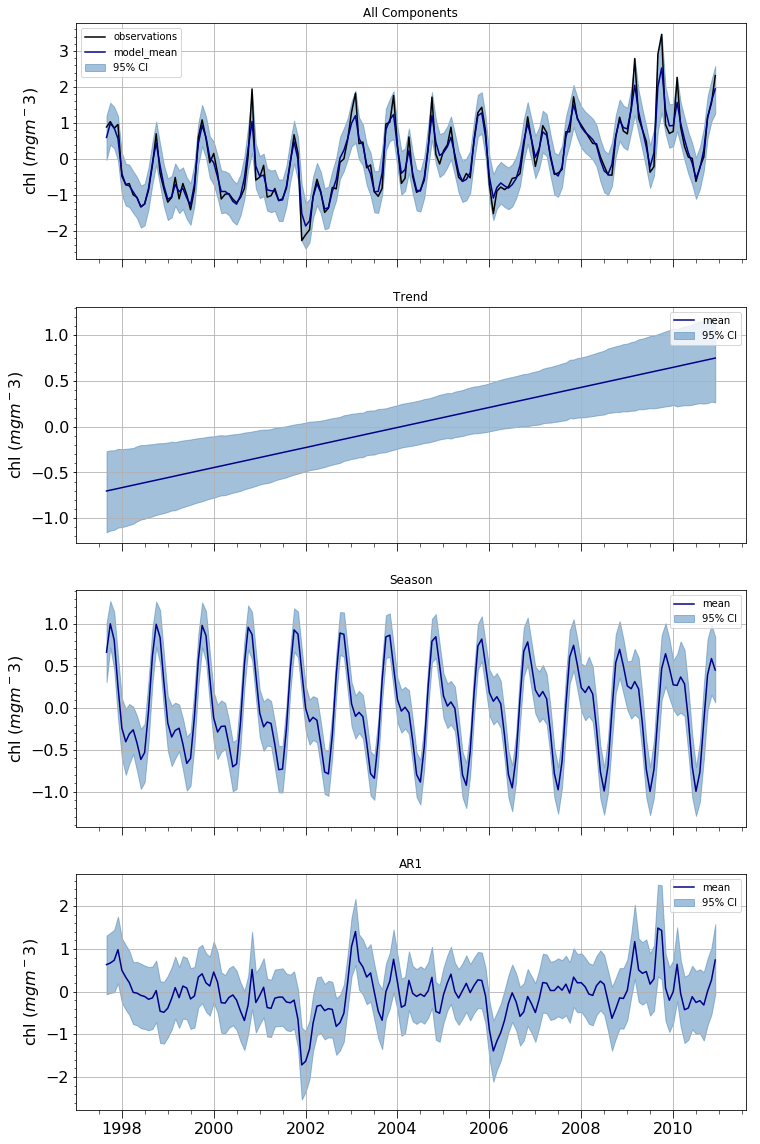

In [71]:
mod5_mu_us = std_scaler.inverse_transform(ts_mod_5_mu)
mod5_hpd_us = std_scaler.inverse_transform(ts_mod_5_hpd)
mod5_trend_hpd_us = std_scaler.inverse_transform(ts_mod_5_trend_hpd)
mod5_trend_mu_us = std_scaler.inverse_transform(ts_mod_5_trend_mu)
mod5_season_hpd_us = std_scaler.inverse_transform(ts_mod_5_season_hpd)
mod5_season_mu_us = std_scaler.inverse_transform(ts_mod_5_season_mu)
mod5_ar1_hpd_us = std_scaler.inverse_transform(ts_mod_5_ar1_hpd)
mod5_ar1_mu_us = std_scaler.inverse_transform(ts_mod_5_ar1_mu)
f, ax = pl.subplots(nrows=4, sharex=True, figsize=(12, 20))
plot_component(ax[0], d_iostz.index, ts_mod_5_mu, hpd_=ts_mod_5_hpd,
               obs=y_s, line_label='model_mean',
               y_axis_label='chl $(mg m^-3)$', ax_title='All Components')
plot_component(ax[1], d_iostz.index, ts_mod_5_trend_mu, hpd_=ts_mod_5_trend_hpd,
               line_label='mean', y_axis_label='chl $(mg m^-3)$',
              ax_title='Trend')
plot_component(ax[2], d_iostz.index, ts_mod_5_season_mu, hpd_=ts_mod_5_season_hpd,
               line_label='mean', y_axis_label='chl $(mg m^-3)$',
              ax_title='Season')
plot_component(ax[3], d_iostz.index, ts_mod_5_ar1_mu, hpd_=ts_mod_5_ar1_hpd,
              line_label='mean', y_axis_label='chl $(mg m^-3)$', ax_title='AR1')

In [69]:
pm.summary(trace_5, varnames=vars_)

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
intercept,-0.702773,0.226080,0.003271,-1.155062,-0.269016,4582.773666,1.000160
slope,0.009147,0.002464,0.000033,0.004332,0.014028,4829.893189,1.000418
amp__0,0.667671,0.110026,0.001155,0.450880,0.884505,8872.234845,1.000059
amp__1,0.393080,0.079475,0.000726,0.235134,0.549326,15881.738046,1.000081
thresh1,10.480064,0.469853,0.004725,9.573454,11.410631,12139.127125,1.000228
thresh2,11.552481,0.319111,0.002500,10.936431,12.193348,17125.299113,1.000086
wl_1,1.941707,0.011422,0.000106,1.919245,1.964353,11516.422607,1.000208
wl_2,0.955897,0.003947,0.000034,0.948013,0.963453,15734.391590,1.000164


In [81]:
with pm.Model() as m6:
    # overall estimation
    nuMinusOne = pm.Exponential('nuMinusOne', 1/29)
    nu_ = nuMinusOne + 1
    lam_ = pm.Gamma('lam', 10, 2)
    
    # seasonality estimation
    thresh = pm.Normal('thresh', 10, shape=3)
    amp = pm.HalfNormal('amp', 5, shape=3)
    wl = pm.Uniform('wl', 0, 5, shape=3)
    season_1 = amp[0] * tt.sin((x - thresh[0]) / wl[0])
    season_2 = amp[1] * tt.sin((x - thresh[1]) / wl[1])
    season_3 = amp[2] * tt.sin((x - thresh[2]) / wl[2])
    season = pm.Deterministic('season', season_1 + season_2 + season_3)
    
    # trend estimation
    slp = pm.Normal('slope', 0, 1)
    itc = pm.Normal('intercept', 0, 1)
    trend = pm.Deterministic('trend', itc + slp * x)
       
    # residual estimation
    k_ = pm.Uniform('k', -1.1, 1.1)
    tau_ = pm.Gamma('tau', 10, 3)
    ar1 = pm.AR1('ar1', k=k_, tau_e=tau_, shape=y.size)

    #e_t = pm.Normal('e_t', 0, 1, shape=y.size)
    #mu_ = trend + season + e_t
    mu_ = pm.Deterministic('mu_', trend + season + ar1)
    y_lik = pm.StudentT('y_lik', mu=mu_, lam=lam_, nu=nu_, observed=y_s)

In [ ]:
with m6:
    trace_6 = pm.sample(7000, tune=10000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ar1, tau_log__, k_interval__, intercept, slope, wl_interval__, amp_log__, thresh, lam_log__, nuMinusOne_log__]
100%|██████████| 17000/17000 [09:31<00:00, 29.72it/s]


### Pickle model results and scaler

In [76]:
resDict = dict(models=dict(m4=m4, m5=m5),
               traces=dict(m4=trace_4, m5=trace_5),
               scaler=std_scaler)
with open('./pikleJar/iostz_bayMdl.pkl', 'wb') as f:
    pickle.dump(resDict, f)

In [79]:
resDict.keys(), resDict['models'].keys(), resDict['traces'].keys()

(dict_keys(['models', 'traces', 'scaler']),
 dict_keys(['m4', 'm5']),
 dict_keys(['m4', 'm5']))